<h2>Análise de traços de execução</h2>

<h3>Installs de bibliotecas necessárias</h3>

In [119]:
%pip install findspark pyspark_dist_explore pyspark plotly pandas chart-studio

     ---------------------------------------- 64.4/64.4 KB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 62.8/62.8 KB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 139.0/139.0 KB 4.2 MB/s eta 0:00:00
     ------------------------------------- 160.2/160.2 KB 10.0 MB/s eta 0:00:00
     ---------------------------------------- 61.2/61.2 KB ? eta 0:00:00
Using legacy 'setup.py install' for retrying, since package 'wheel' is not installed.
  Running setup.py install for retrying: started
  Running setup.py install for retrying: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\322010\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


<h4>Primeiro utilizamos o findspark para que o ambiente saiba onde o spark está localizado.</h4>

In [2]:
import findspark

In [3]:
findspark.init()

<h4>Imports(têm de ser feitos após o init do findspark)</h4>

In [118]:
import pyspark
from pyspark_dist_explore import hist
import time
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import math
import sys,os
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType,StructField, LongType, IntegerType,FloatType

ModuleNotFoundError: No module named 'chartstudio'

<h4>Inicializamos uma seção Spark, ou pegamos a que está atualmente em execução</h4>

In [5]:
spark=SparkSession.builder.appName("Sessao").getOrCreate()

In [6]:
sc = spark.sparkContext

<h4>Definimos um schema para o RDD</h4>

In [46]:
instance_events_schema = StructType([ \
    StructField("time",LongType(),True), \
    StructField("type",IntegerType(),True), \
    StructField("collection_id",IntegerType(),False), \
    StructField("priority", IntegerType(), True), \
    StructField("instance_index", IntegerType(), False), \
    StructField("resource_request.cpus", FloatType(), True), \
    StructField("resource_request.memory", FloatType(), True) \
  ])

<h4>Carregamos um arquivo CSV em um RDD(sem cabeçalho e com o schema definido)</h4>

In [58]:
rddCE = spark.read.option("header","true").schema(instance_events_schema).csv("instance_events/instance_events-000000000005.csv")

<h4>Média dos requerimentos de utilização de memória(por tipo de "coisa")</h4>

<p>Ao persistir o RDD, operações subsequentes reutilizarão os dados relativos ao RDD em operações que o envolvam, diminuindo drasticamente o tempo de execução das mesmas</p>

In [42]:
rddCE.persist()

DataFrame[time: bigint, type: int, collection_id: int, priority: int, instance_index: int, resource_request.cpus: float, resource_request.memory: float]

<p>Essa é executada sem cache</p>

In [10]:
rddCE.orderBy('type').groupBy('type').agg({"`memory_resource_request`":'avg'}).show()

+----+----------------------------+
|type|avg(memory_resource_request)|
+----+----------------------------+
|   0|        0.003215060709829252|
|   1|         0.01933770519928046|
|   2|        0.003345685608592...|
|   3|        0.003335462585395...|
|   4|        0.003473938670384...|
|   5|        0.020445465992991966|
|   6|        0.004764337917852076|
|   7|        0.002935408097730315|
|   8|        0.005776905272776365|
|   9|        0.003988534368734...|
|  10|        0.008756889907134162|
+----+----------------------------+



<p>Essa é executada COM cache</p>

In [11]:
rddCE.orderBy('type').groupBy('type').agg({"`cpu_resource_request`":'avg'}).show()

+----+-------------------------+
|type|avg(cpu_resource_request)|
+----+-------------------------+
|   0|     0.009525861089444346|
|   1|     0.009540171341634771|
|   2|     0.009649705901209166|
|   3|     0.009805624388920475|
|   4|     0.009645259130290452|
|   5|     0.008741734786721873|
|   6|     0.014509926217036775|
|   7|     0.009677616500338168|
|   8|     0.018229468438387228|
|   9|     0.013241837398293013|
|  10|     0.011053578572176771|
+----+-------------------------+



<h4>filtra os eventos de tasks com tipo=3(submissão), com valores de tempo dentro do intervalo observado no traço (0<t<MAXINT>>)</h4>

In [40]:
rddCE = rddCE.filter((rddCE.time.isNotNull()) & (rddCE.type==3) & (rddCE.time>0) & (rddCE.time<sys.maxsize))

Converte microssegundo em hora:

In [13]:
def microToHour(x):
    return math.floor(x/3.6e+9)

Define o objeto udf, que pode ser utilizado pra aplicar a função microToHour no RDD

In [14]:
udf_hours = udf(lambda x:microToHour(x),IntegerType())

cria-se nova coluna com o tempo em horas e adiciona-a ao RDD

In [59]:
rddWithH1 = rddCE.withColumn("hour",udf_hours(col("time")))

In [60]:
rddWithH1 = rddWithH1.filter((rddWithH1.time.isNotNull()) & (rddWithH1.time>0) & (rddWithH1.time<sys.maxsize))

Acha as máximas e mínimas das horas

In [25]:
maxTime = rddCE.agg({'time':'max'}).collect()[0][0]
minTime = rddCE.agg({'time':'min'}).collect()[0][0]
maxTime,minTime

(604799625804, 600777673)

In [27]:
rddCE.agg({'time':'count'}).collect()[0][0]/(microToHour(maxTime)-microToHour(minTime))

11904.419161676647

Encontra a quantidade de tasks submetidas por hora, ao iterar por todos os arquivos

In [34]:
minTime = sys.maxsize
maxTime = 0
type3Count = 0
for filename in os.listdir("instance_events"):
    f = os.path.join("instance_events",filename)
    rddCE = spark.read.option("header","true").schema(instance_events_schema).csv(f)
    rddCE.persist()
    rddCE = rddCE.filter((rddCE.time.isNotNull()) & (rddCE.type==3) & (rddCE.time>0) & (rddCE.time<sys.maxsize))
    type3Count = type3Count+rddCE.agg({'time':'count'}).collect()[0][0]
    if rddCE.agg({'time':'count'}).collect()[0][0]>0:
        maxTime = max(maxTime,rddCE.agg({'time':'max'}).collect()[0][0])
        minTime = min(minTime,rddCE.agg({'time':'min'}).collect()[0][0])
    
minTime,maxTime,type3Count/(microToHour(maxTime)-microToHour(minTime))

(600001531, 604799934699, 429141.46706586826)

In [128]:
rddWithHpHour = rddWithH.groupBy('hour').agg({"`resource_request.memory`":'sum'})

In [129]:
rddWithHpHour1 = rddWithH1.groupBy('hour').agg({"`resource_request.memory`":'sum'})

In [127]:
rddWithH1.schema

StructType(List(StructField(time,LongType,true),StructField(type,IntegerType,true),StructField(collection_id,IntegerType,true),StructField(priority,IntegerType,true),StructField(instance_index,IntegerType,true),StructField(resource_request.cpus,FloatType,true),StructField(resource_request.memory,FloatType,true),StructField(hour,IntegerType,true)))

In [81]:
collsToDrop = ("time","collection_id","type","priority","instance_index","resource_request.cpus","resource_request.memory")
rddWithHpHour.drop(*collsToDrop)
rddWithHpHour1.drop(*collsToDrop)

DataFrame[hour: int, sum(resource_request.memory): double]

In [130]:
rddWithHpHour =  rddWithHpHour.withColumnRenamed("sum(resource_request.memory)","m_sum1")
rddWithHpHour1=  rddWithHpHour1.withColumnRenamed("sum(resource_request.memory)","m_sum2")
j = rddWithHpHour1.join(rddWithHpHour,rddWithHpHour1.hour == rddWithHpHour.hour).drop(rddWithHpHour.hour)
j.printSchema()

root
 |-- hour: integer (nullable = true)
 |-- m_sum2: double (nullable = true)
 |-- m_sum1: double (nullable = true)



In [131]:
j=j.withColumn("m_sum1",col("m_sum1")+col("m_sum2")).drop("m_sum2").orderBy("hour")
j.s

gráfico do consumo de memória por hora

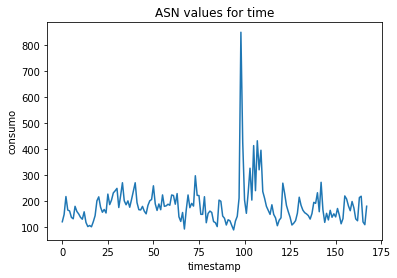

In [123]:
y_ans_val = [val.m_sum1 for val in j.select('m_sum1').orderBy('hour').collect()]
x_ts = [val.hour for val in j.select('hour').orderBy('hour').collect()]

plt.plot(x_ts, y_ans_val)

plt.ylabel('consumo')
plt.xlabel('timestamp')
plt.title('ASN values for time')

plt.show()

In [134]:
a = sc.emptyRDD()
a.isEmpty()

True